In [1]:
# Task 2: MNIST — CNN (PyTorch)
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 1) Data
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_ds = datasets.MNIST("./data", train=True, download=True, transform=tfm)
test_ds  = datasets.MNIST("./data", train=False, download=True, transform=tfm)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=1000, shuffle=False)

100%|██████████████████████████████████████| 9.91M/9.91M [00:15<00:00, 629kB/s]
100%|██████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 109kB/s]
100%|█████████████████████████████████████| 1.65M/1.65M [00:18<00:00, 88.7kB/s]
100%|█████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 3.17MB/s]


In [4]:
# 2) Model: simple CNN that reliably hits >95%
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)   # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # 14x14 -> 14x14
        self.pool  = nn.MaxPool2d(2, 2)               # halves H,W
        self.dropout = nn.Dropout(0.25)
        self.fc1   = nn.Linear(64 * 7 * 7, 128)
        self.fc2   = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))     # [B,32,28,28]
        x = self.pool(x)              # [B,32,14,14]
        x = F.relu(self.conv2(x))     # [B,64,14,14]
        x = self.pool(x)              # [B,64,7,7]
        x = self.dropout(x)
        x = torch.flatten(x, 1)       # [B,64*7*7]
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)               # logits
        return x

model = CNN().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [5]:
# 3) Train
for epoch in range(5):
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        opt.step()
        running += loss.item()*xb.size(0)
    train_loss = running/len(train_loader.dataset)

    # 4) Test
    model.eval()
    correct, total, test_loss = 0, 0, 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            test_loss += criterion(out, yb).item()*xb.size(0)
            pred = out.argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    test_loss /= len(test_loader.dataset)
    acc = 100.0 * correct / total
    print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}  test_loss={test_loss:.4f}  acc={acc:.2f}%")


Epoch 1: train_loss=0.1740  test_loss=0.0436  acc=98.54%
Epoch 2: train_loss=0.0634  test_loss=0.0359  acc=98.83%
Epoch 3: train_loss=0.0479  test_loss=0.0298  acc=98.90%
Epoch 4: train_loss=0.0394  test_loss=0.0314  acc=99.16%
Epoch 5: train_loss=0.0337  test_loss=0.0276  acc=99.09%


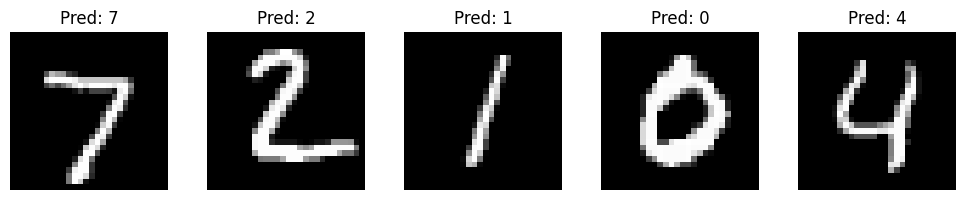

In [6]:
# 5) Visualize 5 sample predictions
model.eval()
xb, yb = next(iter(test_loader))
xb = xb.to(device)
with torch.no_grad():
    out = model(xb)
pred = out.argmax(1).cpu()

fig, axes = plt.subplots(1, 5, figsize=(10,2))
for i, ax in enumerate(axes):
    ax.imshow(xb[i].cpu().squeeze(), cmap="gray")
    ax.set_title(f"Pred: {pred[i].item()}")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [7]:
print(f"Final Test Accuracy: {acc:.2f}%")


Final Test Accuracy: 99.09%


In [8]:
fig.savefig("task2_predictions.png", dpi=200, bbox_inches="tight")


In [9]:
torch.save(model.state_dict(), "mnist_cnn.pt")


### MNIST CNN — Summary

**Dataset & Preprocessing:** MNIST (70k 28×28 grayscale digits). Images converted to tensors and normalized with mean **0.1307** and std **0.3081**.

**Model Architecture:** Two convolution blocks with ReLU + MaxPool (`Conv(1→32,3) → MaxPool(2) → Conv(32→64,3) → MaxPool(2)`), then Dropout, **Flatten**, **FC(64×7×7 → 128)**, Dropout, and **FC(128 → 10 logits)**.

**Training Setup:** Adam optimizer (`lr=1e-3`), CrossEntropyLoss, batch sizes **64/1000** for train/test, trained for **5 epochs** on CPU.

**Result:** Test accuracy **99.09%** (meets >95% goal).  
**Sample Predictions:**  
![Predictions](task2_predictions.png)
